# Clasificador de datos que permita reconocer la marcha - Hold Out

## 0. Initial Setup (carga de libreriías)

In [1]:
import import_ipynb
from functions import * 
from ciervo.plots import emg_plot
import torch.nn as nn

importing Jupyter notebook from functions.ipynb
fatal: destination path 'balu3' already exists and is not an empty directory.
Processing ./balu3
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43718 sha256=5248cd5c220e3e756d48dc2b1d3fd9c66608c20160bfd33b7f7c1a5ccb5c4ab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wf_9vs2j/wheels/1d/f1/b3/dfbb6908bffc070ba2baad77932ab66db0022561f2c4127596
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0


## 1. Data Loading

In [2]:
data_files = load_data()

## 2. Feature Extraction 


Identifica y visualiza cumbres en señal de angulo de la marcha

In [3]:
peaks= find_angle_peaks(data_files)

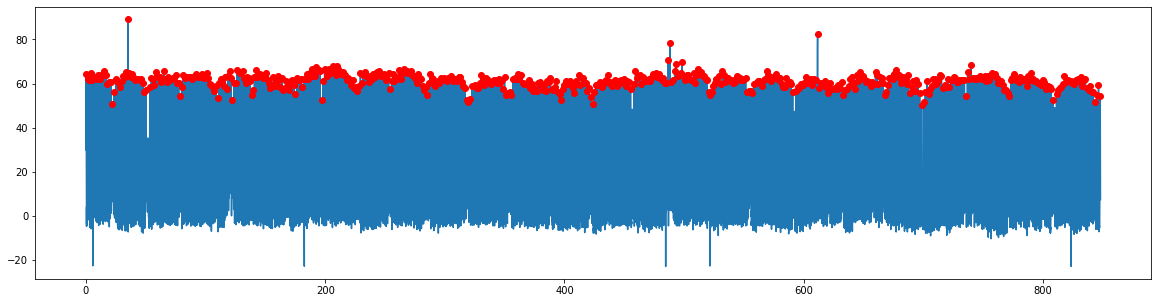

In [4]:
plot_peaks(data_files,peaks)

Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre las cumbres

In [5]:
steps = extract_steps(data_files, peaks)

No handles with labels found to put in legend.


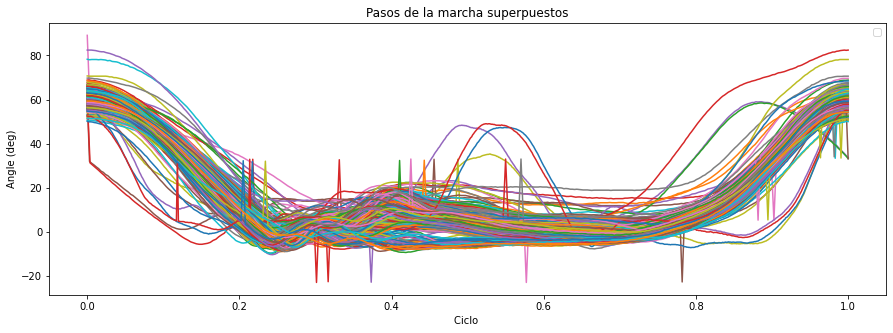

In [6]:
plot_steps(steps)

Preparando datos

In [7]:
step, emg, file= prepare_data(data_files)

<string>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Visualizar datos EMG por musculos diferentes y otros

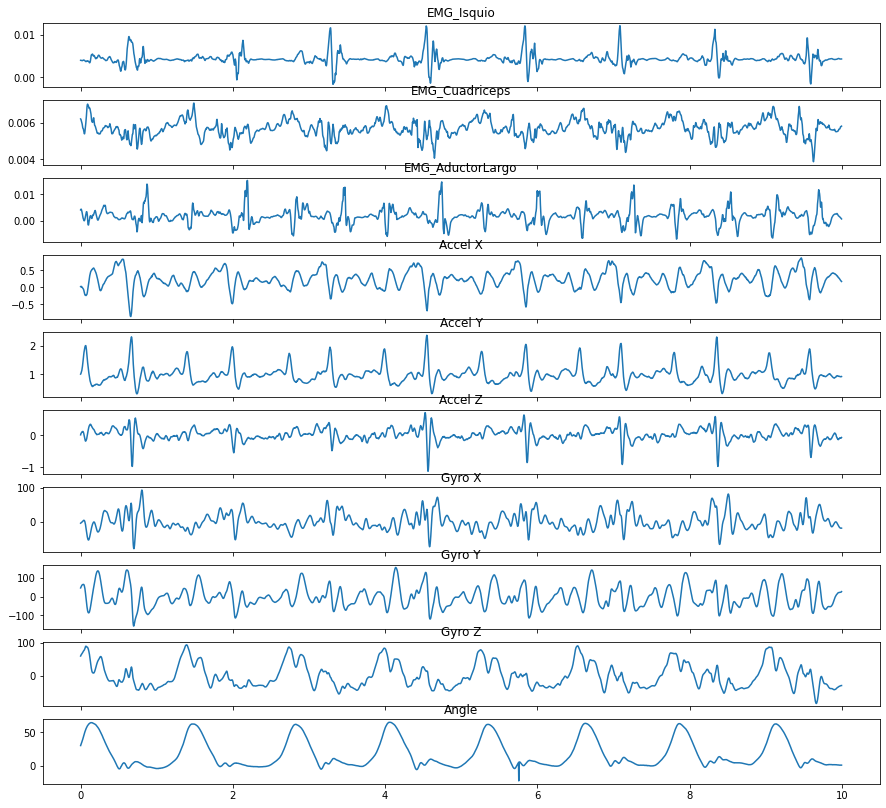

In [8]:
emg_plot(data_files[0])

## 3. Training and testing subsets 

In [9]:
train_data, train_labels, test_data, test_labels, train_feature_names, test_feature_names = prepare_training_and_testing(emg, file, C=[0,1,2], divide=3, num_fases=4)

In [10]:
print(f"Train data: Extracted {train_data.shape[0]} samples with {train_data.shape[1]} features each.")
print(f"Train labels shape: {train_labels.shape}")
print("-----------------------------------------------------------------------")
print(f"Test data: Extracted {test_data.shape[0]} samples with {test_data.shape[1]} features each.")
print(f"Test labels shape: {test_labels.shape}")
print("-----------------------------------------------------------------------")

Train data: Extracted 5156 samples with 60 features each.
Train labels shape: (5156,)
-----------------------------------------------------------------------
Test data: Extracted 2620 samples with 60 features each.
Test labels shape: (2620,)
-----------------------------------------------------------------------


In [11]:
train_data, test_data = clean_normalized_feature_selection(train_data, test_data)
print(train_data.shape)

(5156, 29)


In [12]:
train_data, test_data = sfs_selection(train_data,test_data,train_labels,n_indices=5)

[28 26  8  5 14]


## 4. Classification & Evaluation

 ### Simple NN
 

In [13]:
# Hiperparametros
input_size = train_data.shape[1]
hidden_size = 100
num_fases = 4
output_size = num_fases
learning_rate = 0.001
num_epochs = 100

# Crear el modelo
model = SimpleNN(input_size, hidden_size, output_size)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Preparar los datos
train_loader, test_tensor, test_labels_tensor = prepare_data_SimpleNN(train_data,train_labels,test_data, test_labels)

#Entrenar el modelo
train_model_SimpleNN(model,criterion,optimizer,train_loader,num_epochs)

#Evaluar el modelo
evaluate_model_SimpleNN(model,test_tensor,test_labels_tensor)

Epoch [10/100], Loss: 0.4330
Epoch [20/100], Loss: 0.4472
Epoch [30/100], Loss: 0.2271
Epoch [40/100], Loss: 0.2398
Epoch [50/100], Loss: 0.2190
Epoch [60/100], Loss: 0.1560
Epoch [70/100], Loss: 0.1287
Epoch [80/100], Loss: 0.3013
Epoch [90/100], Loss: 1.4474
Epoch [100/100], Loss: 0.1480
Accuracy: 0.6889312977099237%


### CNN

In [14]:
#preparar datos
train_loader, test_loader, test_labels_tensor, train_data_tensor = prepare_data_CNN(train_data, train_labels, test_data, test_labels)

Epoch 10/100, Train Loss: 0.38332933748577847, Val Loss: 0.649020204456841
Epoch 20/100, Train Loss: 0.3446700705882208, Val Loss: 0.6746828168994043
Epoch 30/100, Train Loss: 0.3098468840306188, Val Loss: 0.7375041942407445
Epoch 40/100, Train Loss: 0.3006780660354797, Val Loss: 0.7213223916364879
Epoch 50/100, Train Loss: 0.2969493691660004, Val Loss: 0.7096518434402419
Epoch 60/100, Train Loss: 0.2879095683219256, Val Loss: 0.7946070788837061
Epoch 70/100, Train Loss: 0.2845297798422384, Val Loss: 0.8532703426189538
Epoch 80/100, Train Loss: 0.2794924949836216, Val Loss: 0.7823954700696759
Epoch 90/100, Train Loss: 0.27601134685086615, Val Loss: 0.7506799289002651
Epoch 100/100, Train Loss: 0.27537392387971465, Val Loss: 0.73127032071352


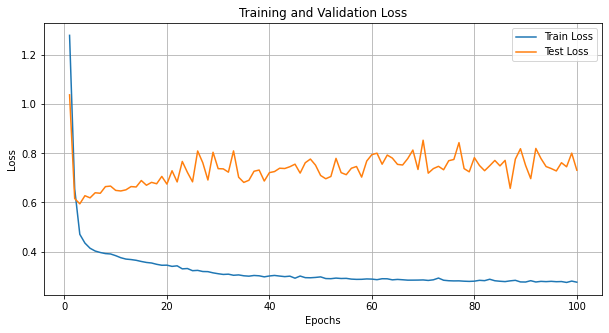

Accuracy of CNN: 0.700381679389313


In [15]:
# Obtener la longitud de la secuencia para inicializar el modelo
input_length = train_data_tensor.shape[2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = GaitCNN(input_length,num_fases=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

#entrenamiento modelo
train_loss, test_loss = train_model_CNN(cnn_model,device,criterion,optimizer, train_loader, test_loader, num_epochs=100)

#graficar
plot_loss_CNN(train_loss, test_loss, num_epochs=100)

#evaluar modelo
evaluate_model_CNN(cnn_model, test_loader, test_labels_tensor)

### RNN

Epoch 5/150, Train Loss: 0.5446501180161665, Val Loss: 0.711067003447835
Epoch 10/150, Train Loss: 0.46959684163699916, Val Loss: 0.678246714356469
Epoch 15/150, Train Loss: 0.4420086000988513, Val Loss: 0.7328937693340022
Epoch 20/150, Train Loss: 0.4160927442120917, Val Loss: 0.7043580151185757
Epoch 25/150, Train Loss: 0.39677887143176277, Val Loss: 0.659013342021442
Epoch 30/150, Train Loss: 0.375445004598594, Val Loss: 0.7350256006892134
Epoch 35/150, Train Loss: 0.3434885542517827, Val Loss: 0.7137058324566702
Epoch 40/150, Train Loss: 0.3106207255917935, Val Loss: 0.7174896428861269
Epoch 45/150, Train Loss: 0.29135228123193907, Val Loss: 0.6952081806049114
Epoch 50/150, Train Loss: 0.28984266537943004, Val Loss: 0.7224323722284015
Epoch 55/150, Train Loss: 0.2856359178269351, Val Loss: 0.7513165026903152
Epoch 60/150, Train Loss: 0.27483591129198487, Val Loss: 0.8042646735543157
Epoch 65/150, Train Loss: 0.2766056809068462, Val Loss: 0.7986995256165179
Epoch 70/150, Train Loss:

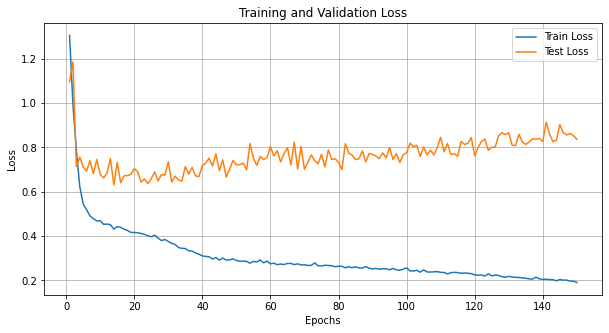

Accuracy of RNN: 0.7099236641221374


In [16]:
#asegurar q train_data tenga 3 dimensiones
train_data, test_data = preprocess_data_RNN(train_data, test_data)

#hiperparametro
input_size = train_data.shape[2]
hidden_size = 64
num_layers = 2
batch_size = 32
num_epochs = 150
num_fases=4
num_classes = num_fases

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Crear dataloaders
train_loader, test_loader = create_dataloaders_RNN(train_data, train_labels, test_data, test_labels, batch_size)

#inicializar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = GaitRNN(input_size, hidden_size, num_layers, num_fases).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

#entrenar
train_loss, test_loss = train_model_RNN(rnn_model, train_loader,test_loader, criterion, optimizer, num_epochs, device)

#graficar
plot_loss_RNN(train_loss, test_loss)

#evaluar
evaluate_model_RNN(rnn_model, test_loader, test_labels, device)